In [512]:
import tensorflow as tf
import keras
from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
import numpy
from __future__ import print_function
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR

In [513]:
#Reading the data
data = pd.read_csv('hist.csv')

In [514]:
# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)

    return scaler, train_scaled, test_scaled

#Preparing the engine data for predicting RUL
def prepare_engine(engine, scaler):
    
    #Removing unit number and time in cycles column
    engine = engine.iloc[:,2:len(engine.columns)]
    engine = engine.values
    
    #Scaling using trained scaler
    engine = engine.reshape(engine.shape[0], engine.shape[1])
    engine = scaler.transform(engine)

    return engine

In [515]:
#Assigning the same prediction variable RUL to each engine 
unit_2RUL = data.loc[:,['unit number', 'RUL']].groupby('unit number').count().to_dict()['RUL']
data.loc[:,'RUL_correct'] = data.loc[:,'unit number']
data.replace({"RUL_correct":unit_2RUL}, inplace = True)
data.drop('RUL', axis = 1, inplace= True)
data.rename(columns= {'RUL_correct':'RUL'}, inplace = True)

In [516]:
#Making number of rows in each test engine divisible by batch_size = 4
def delete_extra_rows(df):
    if (len(df['unit number'])%4 != 0):
        return df.iloc[0:len(df)-(len(df)%4),:]
    
    else:
        return df
data = data.groupby('unit number').apply(delete_extra_rows).reset_index(drop= True)

In [517]:
#Splitting training and test data (last 20 engines)
def get_test(df):
    if(df['unit number'].values[0]>80):
        return df

def get_train(df):
    if(df['unit number'].values[0]<=80):
        return df
        
test = data.groupby('unit number').apply(get_test).reset_index(drop = True).dropna(axis= 0)
train = data.groupby('unit number').apply(get_train).reset_index(drop = True).dropna(axis = 0)

In [518]:
#Removing unit number and time in cycles column
#For train
train_series_x = train.iloc[:,2:len(data.columns)-1]
train_series_y = train.iloc[:,-1]
#For test
test_series_x = test.iloc[:,2:len(data.columns)-1]
test_series_y = test.iloc[:,-1]

In [519]:
raw_test_x = test_series_x.values
raw_train_x = train_series_x.values

raw_test_y = test_series_y.values
raw_train_y = train_series_y.values

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(raw_train_x, raw_test_x)

#Renaming
train_x = train_scaled
test_x = test_scaled
train_y = raw_train_y
test_y = raw_test_y

In [520]:
timesteps = 1
input_dim = train_x.shape[1]
batch_size = 4
size_latent = 6
size_linear_layer = 5

#Reshaping the input to be fit to be input to the LSTM
train_x = train_x.reshape(np.shape(train_x)[0], timesteps, input_dim)

inputs = Input(batch_shape=(batch_size,timesteps, input_dim))

encoded = LSTM(size_latent, return_sequences = True)(inputs)
encoded = LSTM(size_latent,return_sequences = True)(encoded)
encoded = LSTM(size_latent,return_sequences = True)(encoded)
encoded = Dense(size_linear_layer, activation = 'relu')(encoded)

decoded = Dense(size_latent, activation = 'relu')(encoded)
decoded =  LSTM(size_latent,return_sequences = True)(decoded)                                   
decoded =  LSTM(size_latent,return_sequences = True)(decoded)
decoded =  LSTM(size_latent, return_sequences = True)(decoded)
decoded = Dense(input_dim, activation = 'relu')(decoded)

sequence_autoencoder = tf.keras.models.Model(inputs, decoded)

encoder = tf.keras.models.Model(inputs,encoded)

sequence_autoencoder.compile(loss='mean_squared_error', optimizer='Adam')

history_data = sequence_autoencoder.fit(train_x, train_x, epochs=100, batch_size=batch_size, shuffle=False)


Epoch 1/100
16008/16008 [==============================]16008/16008 [==============================] - 73s 5ms/step - loss: 0.3853

Epoch 2/100
16008/16008 [==============================]16008/16008 [==============================] - 74s 5ms/step - loss: 0.3798

Epoch 3/100
16008/16008 [==============================]16008/16008 [==============================] - 68s 4ms/step - loss: 0.3798

Epoch 4/100
16008/16008 [==============================]16008/16008 [==============================] - 68s 4ms/step - loss: 0.3797

Epoch 5/100
16008/16008 [==============================]16008/16008 [==============================] - 68s 4ms/step - loss: 0.3797

Epoch 6/100
16008/16008 [==============================]16008/16008 [==============================] - 69s 4ms/step - loss: 0.3798

Epoch 7/100
16008/16008 [==============================]16008/16008 [==============================] - 69s 4ms/step - loss: 0.3797

Epoch 8/100
16008/16008 [==============================]16008/16008 [=======

16008/16008 [==============================]16008/16008 [==============================] - 83s 5ms/step - loss: 0.3782

Epoch 62/100
16008/16008 [==============================]16008/16008 [==============================] - 89s 6ms/step - loss: 0.3782

Epoch 63/100
16008/16008 [==============================]16008/16008 [==============================] - 84s 5ms/step - loss: 0.3782

Epoch 64/100
16008/16008 [==============================]16008/16008 [==============================] - 89s 6ms/step - loss: 0.3782

Epoch 65/100
16008/16008 [==============================]16008/16008 [==============================] - 89s 6ms/step - loss: 0.3781

Epoch 66/100
16008/16008 [==============================]16008/16008 [==============================] - 94s 6ms/step - loss: 0.3781

Epoch 67/100
16008/16008 [==============================]16008/16008 [==============================] - 92s 6ms/step - loss: 0.378116008 [============================>.] - E

Epoch 68/100
16008/16008 [==============

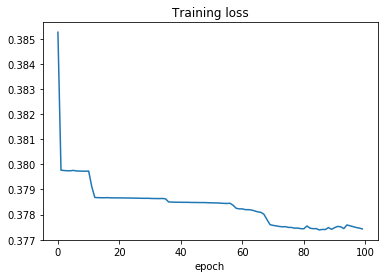

In [521]:
#Plotting the training loss with epochs
fig = plt.figure()
plt.plot(history_data.history['loss'])
plt.title('Training loss')
plt.xlabel('epoch')
plt.show()

In [522]:
#For training the regression model for predicting RUL

#Train data
#Calculating the embeddings which would be input to the regression classifier
#Calculating the output for each batch (RUL)

embeddings = encoder.predict(train_x, batch_size= batch_size)
start_batch = 0
mean_embeddings_train = []
output_train = []
while(start_batch < train_x.shape[0] - 1):
    mean_embeddings_train.append(list(np.mean(embeddings[start_batch: start_batch + batch_size, :], axis = 0)[0,:]))
    output_train.append(train_y[start_batch: start_batch + batch_size][0])
    start_batch += batch_size

    
#Test data
#Reshaping test data to be of same shape to be input to the encoder
test_x = test_x.reshape(np.shape(test_x)[0], timesteps, input_dim)

embeddings = encoder.predict(test_x, batch_size= batch_size)
start_batch = 0
mean_embeddings_test = []
output_test = []
while(start_batch < test_x.shape[0] - 1):
    mean_embeddings_test.append(list(np.mean(embeddings[start_batch: start_batch + batch_size, :], axis = 0)[0,:]))
    output_test.append(test_y[start_batch: start_batch + batch_size][0])
    start_batch += batch_size


In [523]:
#Combing training and testing embeddings and outputs for grid search Cross validation
mean_embeddings_train.extend(mean_embeddings_test)
output_train.extend(output_test)

In [530]:
clf = SVR(kernel = 'rbf')
parameters = {'C':[0.01, 0.1, 1, 10, 20, 50,100, 500], 'gamma': [0.01, 0.1, 1, 10, 50, 100]}
gs = GridSearchCV(clf, parameters)
gs.fit(mean_embeddings_train, output_train)
best_params = gs.best_params_
print("Best Parameters: {}".format(gs.best_params_))
print("Best test cross validation R2 score {}".format(np.max(gs.cv_results_['mean_train_score'])))

KeyboardInterrupt: 

In [532]:
#Fitting the regression model with best parameters
clf = SVR(kernel = 'rbf', C = 100, gamma = 0.1)
clf.fit(mean_embeddings_train, output_train)

SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [535]:
engine_tul = {}

In [536]:
#Walk forward validation method for predicting the RUL for testing

for engine_no in [101, 102, 103, 104, 124, 125, 134]:
    
    #Initializing the engine tul dictionary
    engine_tul[str(engine_no)]= []
    
    
    #Reading the engine file
    file_name = 'Engine' + str(engine_no) + '.csv'
    engine = pd.read_csv(file_name)
    
    if(engine_no == 103):
        engine.loc[:,'unit number'] = 3
        
    #Preparing the engine for the prediction
    engine = prepare_engine(engine, scaler)
    
    print('\n')
    print('Current Engine: {}'.format(engine_no))
    
    
    start_batch = 0
    predicted_rul = []
    while(start_batch + batch_size < len(engine) -1):


        #Get current batch from the full engine data
        cur_engine = engine[start_batch: start_batch + batch_size,:]

        #Reshaping the current engine batch to be input to the Autoencoder
        cur_engine = cur_engine.reshape(cur_engine.shape[0], timesteps, cur_engine.shape[1])

        #Calculating the embedding vector for the current batch
        embeddings = encoder.predict(cur_engine, batch_size = batch_size)

        #Taking the mean of the embeddings for this batch
        mean_embeddings = np.mean(embeddings, axis = 0)

        #Using regression model to predict the output RUL for current batch
        cur_rul = clf.predict(mean_embeddings)

        #Appending the cur_rul to the previous batch rul vector
        predicted_rul.append(cur_rul)

        #RUL prediction at the current timestamp
        print("TULprediction at current cycle {}: {}".format(start_batch + batch_size + 1, np.mean(predicted_rul)))
        
        engine_tul[str(engine_no)].append(np.mean(predicted_rul))
        
        #Updating the start_batch
        start_batch+=batch_size



Current Engine: 101
TULprediction at current cycle 5: 210.16065530261693
TULprediction at current cycle 9: 209.2453343343088
TULprediction at current cycle 13: 210.7392851004613
TULprediction at current cycle 17: 210.894803674741
TULprediction at current cycle 21: 211.098770712089
TULprediction at current cycle 25: 210.70202008763792
TULprediction at current cycle 29: 210.18683399095192


Current Engine: 102
TULprediction at current cycle 5: 203.41628892837238
TULprediction at current cycle 9: 202.2459076064315
TULprediction at current cycle 13: 201.56715851643352
TULprediction at current cycle 17: 201.65778790580544
TULprediction at current cycle 21: 201.6231004544291
TULprediction at current cycle 25: 201.77695384284007
TULprediction at current cycle 29: 201.46814032822408
TULprediction at current cycle 33: 201.4395724097432
TULprediction at current cycle 37: 201.46985839713307
TULprediction at current cycle 41: 201.52583440364532
TULprediction at current cycle 45: 201.419971525615

TULprediction at current cycle 161: 207.6915960039102
TULprediction at current cycle 165: 208.08308067829904
TULprediction at current cycle 169: 208.2093170552503
TULprediction at current cycle 173: 208.39895588824618
TULprediction at current cycle 177: 208.54189652105254
TULprediction at current cycle 181: 208.76174618284904
TULprediction at current cycle 185: 208.98209124225997
TULprediction at current cycle 189: 209.10027815305284
TULprediction at current cycle 193: 209.25030690569
TULprediction at current cycle 197: 209.38735978991642
TULprediction at current cycle 201: 209.4128665353209
TULprediction at current cycle 205: 209.52385754495214
TULprediction at current cycle 209: 209.82545372014027
TULprediction at current cycle 213: 209.85360276900715
TULprediction at current cycle 217: 209.8849111899754
TULprediction at current cycle 221: 209.8471864232389
TULprediction at current cycle 225: 209.77207238092265
TULprediction at current cycle 229: 209.74670549861628
TULprediction at c

In [538]:
#RUL prediction
#Negative RUL means 0 RUL

print('RUL for engine 101: {}'.format(int(np.mean(engine_tul['101']) - 31)))
print('RUL for engine 102: {}'.format(int(np.mean(engine_tul['102']) - 49)))
print('RUL for engine 103: {}'.format(int(np.mean(engine_tul['103']) - 126)))
print('RUL for engine 104: {}'.format(int(np.mean(engine_tul['104']) - 106)))
print('RUL for engine 124: {}'.format(int(np.mean(engine_tul['124']) - 186)))
print('RUL for engine 125: {}'.format(int(np.mean(engine_tul['125']) - 48)))
print('RUL for engine 134: {}'.format(int(np.mean(engine_tul['134']) - 395)))


RUL for engine 101: 179
RUL for engine 102: 152
RUL for engine 103: 69
RUL for engine 104: 95
RUL for engine 124: 32
RUL for engine 125: 158
RUL for engine 134: -189
